In [1]:
import os
import numpy as np
import itertools as it
import pandas as pd
from types import SimpleNamespace
import matplotlib.pyplot as plt

# see https://stackoverflow.com/questions/41385708/multiprocessing-example-giving-attributeerror
# for why we use multiprocess rather than multiprocessing,
from multiprocess import Pool

import src.utils as utils
import src.initial as initial
import src.target as target
from src.proposals import norm
import src.mcmc as mcmc

utils.configure_pd(pd)
utils.configure_plt(plt)

In [2]:
%%time

ell2 = 2.38**2
d_grid = list(np.linspace(1, 10, 10, dtype=int))
mode_pairs_grid = [('full_max_indep','na'),
                   ('full_max_refl','na'),
                   ('max_indep','same_u'),
                   ('max_indep','cond_same_u'),
                   ('max_refl','same_u'),
                   ('max_refl','cond_same_u')
]

# For paper, n_rep=1000. This take about 25 min running on 6 cores
# We iterate until meeting occurs, so n_iter = max iters to run each chain for
pl = utils.add_iter([{'n_rep':1000,
                      'n_iter':1000000,
                      'prop_mode':prop_mode, 'ar_mode':ar_mode,
                      'd':d, 'ell2':2.38**2}
                     for (d, (prop_mode, ar_mode)) in it.product(d_grid, mode_pairs_grid)])

def f(par):
    n = SimpleNamespace(**par)
    pr = f' - d = {n.d}, prop_mode = {n.prop_mode}, ar_mode = {n.ar_mode} ({n.i}/{n.i_total})'

    init = initial.Initialize(d=n.d, mode='target_indep')
    prop = norm.NormalProposal(d=n.d, sigma2=n.ell2/n.d, prop_mode=n.prop_mode)
    targ = target.NormalTarget(d=n.d, sigma2=1)

    cmh = mcmc.CoupledMH(init, prop, targ,
                         break_condition='meet', ar_mode=n.ar_mode)
    cmh.run(n_iter=n.n_iter, n_rep=n.n_rep, verbose=True, pr_postfix=pr)

    df0 = cmh.return_df()
    df0['mode'] = f'{n.prop_mode} {n.ar_mode}'
    return df0

df_list = []
with Pool(os.cpu_count()-2) as p:
    df_list += p.map(f, pl)

df = pd.concat(df_list)

100 - d = 1, prop_mode = full_max_indep, ar_mode = na (0/60)
100 - d = 2, prop_mode = full_max_indep, ar_mode = na (6/60)
200 - d = 1, prop_mode = full_max_indep, ar_mode = na (0/60)
100 - d = 3, prop_mode = full_max_indep, ar_mode = na (12/60)
300 - d = 1, prop_mode = full_max_indep, ar_mode = na (0/60)
200 - d = 2, prop_mode = full_max_indep, ar_mode = na (6/60)
100 - d = 1, prop_mode = max_indep, ar_mode = cond_same_u (3/60)
400 - d = 1, prop_mode = full_max_indep, ar_mode = na (0/60)
300 - d = 2, prop_mode = full_max_indep, ar_mode = na (6/60)
200 - d = 3, prop_mode = full_max_indep, ar_mode = na (12/60)
500 - d = 1, prop_mode = full_max_indep, ar_mode = na (0/60)
400 - d = 2, prop_mode = full_max_indep, ar_mode = na (6/60)
600 - d = 1, prop_mode = full_max_indep, ar_mode = na (0/60)
100 - d = 2, prop_mode = max_indep, ar_mode = cond_same_u (9/60)300 - d = 3, prop_mode = full_max_indep, ar_mode = na (12/60)

700 - d = 1, prop_mode = full_max_indep, ar_mode = na (0/60)
200 - d = 1, 

In [8]:
#df.to_hdf('df_fig7.h5','df')

# process output
df_t = df.groupby(['d','rep_id','mode'])['t'].max().reset_index()
df_t = df_t.groupby(['d','mode'])[['t']]

df_avg = df_t.mean()#.reset_index()
df_avg['se'] = df_t.sem()
df_avg.reset_index(inplace=True)

df_avg = df_avg.pivot(index='d',columns='mode', values=['t','se'])
df_avg.loc[0] = 0.
df_avg = df_avg.reset_index()
df_avg.sort_values('d', inplace=True)

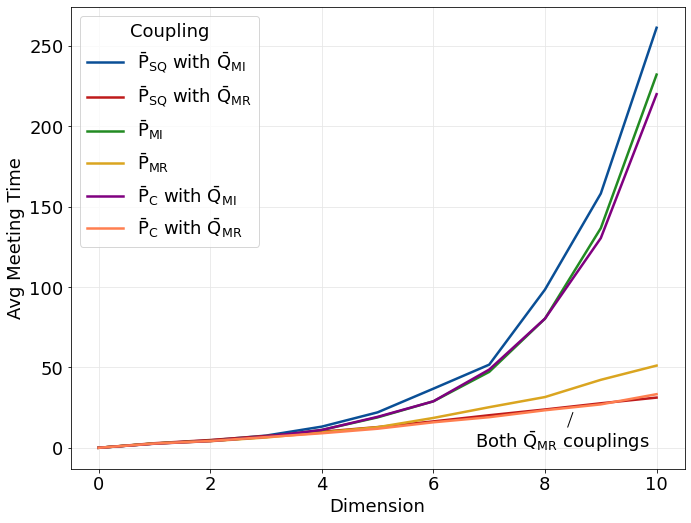

In [31]:
# Produce Figure 7: avg meeting time as a function of dimension and coupling

# Note that we want the order and labeling to be the same for all figures
mode_pairs = [
    ('max_indep same_u', r'$\bar{P}_{SQ}$ with $\bar{Q}_{MI}$'),
    ('max_refl same_u', r'$\bar{P}_{SQ}$ with $\bar{Q}_{MR}$'),
    ('full_max_indep na', r'$\bar{P}_{MI}$'),
    ('full_max_refl na', r'$\bar{P}_{MR}$'),
    ('max_indep cond_same_u', r'$\bar{P}_C$ with $\bar{Q}_{MI}$'),
    ('max_refl cond_same_u', r'$\bar{P}_C$ with $\bar{Q}_{MR}$')
]

mode_disp = [m[0] for m in mode_pairs]
mode_labs = [m[1] for m in mode_pairs]

mode_disp = [('t',m) for m in mode_disp]

df_avg.plot(x='d', y=mode_disp, marker='')

plt.annotate(r'Both $\bar{Q}_{MR}$ couplings',
             xy=(8.5, 22), xytext=(6.75, 0),
             arrowprops={'arrowstyle':'-','shrinkA':0, 'shrinkB':0})

plt.xlabel('Dimension')
plt.ylabel('Avg Meeting Time')
plt.legend(labels=mode_labs, ncol=1, title='Coupling')

#plt.savefig('meeting_times_labels.pdf')

plt.show()